# Graph Experiment 1
Train a net, recording its path in `neo4j` graph database

# Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pprint import pprint
import neo4j

In [3]:
import hashlib
from hashlib import sha256
from pprint import pprint
import time

## Connecting

Need to get the `gpu-jupyter` and the `neo4j` docker containers connected. If run bare, something like:

    docker network connect gpu-jupyter_default gpu-jupyter 
    docker network connect gpu-jupyter_default neo4j
    docker network inspect gpu-jupyter_default 
    
Docker has better ways than this.

In [4]:
driver = neo4j.GraphDatabase.driver("neo4j://172.19.0.2:7687", auth=("neo4j", "test"))

In [5]:
driver.verify_connectivity()

<ipython-input-5-b734c674563a>:1: ExperimentalWarning: The configuration may change in the future.
  driver.verify_connectivity()


{IPv4Address(('172.19.0.2', 7687)): [{'ttl': 300,
   'servers': [{'addresses': ['172.19.0.2:7687'], 'role': 'WRITE'},
    {'addresses': ['172.19.0.2:7687'], 'role': 'READ'},
    {'addresses': ['172.19.0.2:7687'], 'role': 'ROUTE'}]}]}

# Utility functions

In [6]:
def randomize_net(net):
    for layer in net.layers:
        if hasattr(layer, 'randomize'):
            layer.randomize()

## `numpy` array store

In [7]:
from graph_utils_neo4j import NumpyStore

# The Model
    Investigation -> Experiment -> multiple ResultDAGs
`ResultDAG` is

    (netState, params)-[mutation]->(netState, params)-[mutation ...
                     +-[mutation]->(netstate, params) ...
etc. `mutation` can be a learning trajectory, or an edit.

Perhaps `mutation` can be expressed in python.

Generally the results of experiments are preferred to be reproducible, but they won't always be, when they import entropy.

## Some neural nets

In [8]:
from nn import Network, Layer, IdentityLayer, AffineLayer, MapLayer
from nnbench import NetMaker, NNMEG

In [9]:
mnm = NetMaker(NNMEG)
xor_net = mnm('2x2tx1t')
#adc_net = mnm('1x8tx8tx3t')
adc_net = mnm('1x8tx8tx3tx3t')

## ... and training data

In [10]:
xor_training_batch = (np.array([[-0.5, -0.5],
                            [-0.5,  0.5],
                            [ 0.5,  0.5],
                            [ 0.5, -0.5]]),
                  np.array([[-0.5],
                            [ 0.5],
                            [-0.5],
                            [ 0.5]]))

In [11]:
def adc(input):
    m = max(0, min(7, int(8*input)))
    return np.array([(m>>2)&1, (m>>1)&1, m&1]) * 2 - 1

vadc = lambda v: np.array([adc(p) for p in v])
#plot_ADC(vadc)

In [12]:
x = np.arange(0, 1, 1.0/(8*8)).reshape(-1,1) # 1 point in each output region
adc_training_batch = (x, vadc(x))

### We use `adc_net`

In [13]:
net = adc_net
training_batch = adc_training_batch

# The graph database

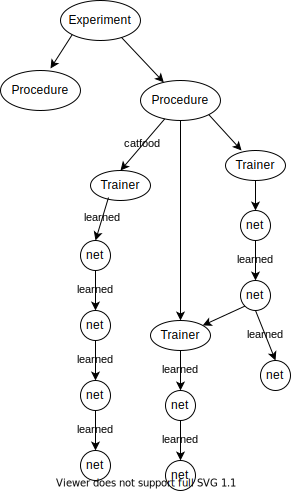

In [14]:
from IPython.display import SVG, display
display(SVG('ml graphdb structure r1.svg'))

## 

## First net node

In [15]:
def add_start(tx, facts, net):
    tx.run("MERGE (:net "
           "{shorthand: $shorthand, "
           "ksv: $ksv, "
           "loss: $loss, "
           "ts: $ts, "
           "experiment: $experiment, "
           "head: $head}) ",
           **facts)

## Trained net nodes

In [16]:
def add_subsequent(tx, facts, net):
    tx.run("MATCH (a:net {ksv: $prior_ksv}) "
           "MERGE (a)-"
           "[:LEARNED "
               "{batch_points: $batch_points, "
               "etas: $etas, "
               "eta_change_batches: $eta_change_batches, "
               "batches_this_segment: $batches_this_segment, "
               "losses: $loss, "
               "loss_steps: $loss_step, "
               "traj_L2_sqs: $traj_L2_sq, "
               "traj_cos_sq_signeds: $traj_cos_sq_signed, "
               "ts: $ts "
               "}]->"
           "(b:net "
               "{shorthand: $shorthand, "
               "ksv: $ksv, "
               "loss: $end_loss, "
               "ts: $ts, "
               "experiment: $experiment}) ",
           **facts)

## An example experiment's DAG

In [30]:
randomize_net(net)

In [31]:
net.eta = 0.02

## Train, recording trajectory

In [32]:
nps = NumpyStore(driver)

In [33]:
def trainer(net):
    loss = net.losses([training_batch])[0]
    batch_ctr = 0
    while loss > 1e-3:
        batch_ctr_at_seg_start = batch_ctr
        losses = []
        etas = []
        deltas = []
        prior_loss = loss
        while loss / prior_loss > 0.7071 and len(deltas) < 100:
            if not etas or net.eta != etas[-1][1]:
                etas.append([batch_ctr, net.eta])
            loss = net.learn([training_batch])
            if batch_ctr < 100 or batch_ctr % 100 == 0:
                losses.append([batch_ctr, loss])
                deltas.append([batch_ctr, net.deltas()])
            batch_ctr += 1
        #if losses[-1][0] < (batch_ctr-1):
        #    losses.append([batch_ctr, loss])
        if not deltas or deltas[-1][0] < (batch_ctr-1):
            deltas.append((batch_ctr, net.deltas()))
        properties = dict(zip(deltas[0][1]._fields, map(list, (zip(*(v[1] for v in deltas)))))) # RedisGraph has a tuple allergy
        #properties = {}
        properties['batch_points'] = [v[0] for v in deltas]
        #properties['etas'] = etas
        properties['etas'], properties['eta_change_batches'] = (list(v) for v in zip(*etas))
        properties['batches_this_segment'] = batch_ctr - batch_ctr_at_seg_start
        properties['ts'] = time.time()
        properties['shorthand'] = net.shorthand
        properties['ksv'] = nps.store(net.state_vector())
        properties['end_loss'] = net.losses([training_batch])[0]
        properties['experiment'] = 'ADC'
        yield properties

In [34]:
starting_facts = {'shorthand': net.shorthand,
              'ksv': nps.store(net.state_vector()),
              'loss': net.losses([training_batch])[0],
              'ts': time.time(),
              'experiment': 'ADC',
              'head': True,
             }

### Record results as they arrive

In [35]:
with driver.session() as session:
    session.write_transaction(add_start, starting_facts, net)
    prior_ksv = starting_facts['ksv']
    for observations in trainer(net):
        observations['prior_ksv'] = prior_ksv
        prior_ksv = observations['ksv']
        #pprint(observations)
        #observations['etas'] = observations['etas'][0] #DEBUG HACK, FIXME
        session.write_transaction(add_subsequent, observations, net)
        print(f"loss {observations['end_loss']}")

loss 1.7614547710648374
loss 1.2438670300229306
loss 0.8801776582242014
loss 0.6208849772705576
loss 0.44222313574392275
loss 0.31087636213954856
loss 0.21979292335737027
loss 0.15540728552594213
loss 0.10988699974995655
loss 0.0777007265766878
loss 0.05494426387442765
loss 0.038852116826189324
loss 0.02878797713640744
loss 0.023535277763503074
loss 0.020200330015270218
loss 0.017823451114094176
loss 0.0160047822681738
loss 0.014546522170713831
loss 0.013338278137727286
loss 0.012312977105937059
loss 0.01142714864460077
loss 0.010651113936214473
loss 0.009963719645733237
loss 0.00934934153211869
loss 0.008796094678633324
loss 0.008294717582835606
loss 0.007837848580707388
loss 0.007419539423960726
loss 0.007034917363471187
loss 0.00667994343130144
loss 0.006351235072585715
loss 0.006045933110453518
loss 0.005761600045541873
loss 0.005496140957466814
loss 0.0052477409236459365
loss 0.005014814529298707
loss 0.004795964048066384
loss 0.004589943373500806
loss 0.004395624759935091
loss 0.

In [36]:
assert False, "stop here"

AssertionError: stop here